### Load the libraries

In [1]:
# Load the libraries 
import os, sys
import pandas as pd 
from datetime import date
import numpy as np 
import scanpy as sc
import anndata as ad 
import sqlite3
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns
import scrublet as scr

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Print the container version </b></i>

In [2]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-06-11


<i><b> Set the home directory </b></i>

In [3]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

### Load the data

> *** Polioudakis and Trevino datasets (hs_ncx) have been QC-processed for another project. Here, I only uploaded the clean version.

In [4]:
# Load the Polioudakis and Trevino raw counts
adata_hs_ncx = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scmorpho_final/data_versions_tissue/Adata_raw.h5ad")
# Load the Linnarsson raw counts
adata_mm_dge = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/raw/Adata_linnarsson_mm_dg_raw.h5ad")
# Load the Zylka raw counts 
adata_mm_ncx_zylka = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/raw/Adata_zylka_mm_ncx_raw.h5ad")
# Load the Ruan raw counts
adata_mm_ncx_ruan = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/raw/Adata_ruan_mm_ncx_raw.h5ad")

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# Define the count layer
adata_list = [adata_mm_dge, adata_mm_ncx_zylka, adata_mm_ncx_ruan]

for adata in adata_list:
    adata.layers['counts'] = adata.X

In [6]:
# Print number of cells 
adata_list = [adata_mm_dge, adata_mm_ncx_zylka, adata_mm_ncx_ruan]

# Print number of cells and genes per dataset 
for i, adata in enumerate(adata_list):
    print(f"Number of cells and genes in dataset {i+1} is: {adata.X.shape}")

# Print total number of cells (for three datasets)
total_cells = sum(adata.n_obs for adata in adata_list)
print('Total number of cells in mouse datasets is:', total_cells)

Number of cells and genes in dataset 1 is: (24185, 27933)
Number of cells and genes in dataset 2 is: (10931, 21313)
Number of cells and genes in dataset 3 is: (10261, 21862)
Total number of cells in mouse datasets is: 45377


### Data wrangling

In [7]:
# Add the sample id information
## adata_hs_ncx dataset already has the sample_id column
adata_mm_dge.obs['sample_id'] = adata_mm_dge.obs['Sample name (24185 single cells)'].str.split("_").str[:2].str.join("_")
adata_mm_ncx_zylka.obs['sample_id'] = adata_mm_ncx_zylka.obs['CellID'].str.split("_").str[:1].str.join("_")
adata_mm_ncx_ruan.obs['sample_id']= adata_mm_ncx_ruan.obs['cellid'].str.split("_").str[:2].str.join("_")

In [8]:
# Modify the var_names of the Ruan dataset
## Remove the parentheses, extra quotes and commas
adata_mm_ncx_ruan.var_names.astype(str)
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.strip("() ").str.strip("'").str.strip("'$").str.rstrip(",")
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.strip("'$")
## Remove the mmu- prefix 
adata_mm_ncx_ruan.var_names = adata_mm_ncx_ruan.var_names.str.replace("mmu-", "", regex=True)
## Print the output
adata_mm_ncx_ruan.var_names

Index(['0610005C13Rik', '0610007N19Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009D07Rik', '0610009E02Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'Zbtb9', 'Zp3', 'mir-6374', 'mir-6383', 'mir-6418', 'mir-6951',
       'mir-6958', 'mir-7024', 'mir-8106', 'mt-Nd3'],
      dtype='object', length=21862)

In [9]:
# Re-format the obs_name for Ruan and Zylka
## Ruan
adata_mm_ncx_ruan.obs_names = adata_mm_ncx_ruan.obs['cellid']
## Zylka
adata_mm_ncx_zylka.obs_names = adata_mm_ncx_zylka.obs['CellID']

### Doublet removal

In [10]:
# Compute doublet scores 
adata_dict = {
    'adata_mm_dge' : adata_mm_dge, 
    'adata_mm_ncx_zylka' : adata_mm_ncx_zylka, 
    'adata_mm_ncx_ruan' : adata_mm_ncx_ruan,
}

# Create an empty scrub dictionary 
scrub_dict = {}

# Calculate the predicted doublet rates iteratively
for name, adata in adata_dict.items():
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    scrub_dict[name.replace('adata', 'scrub')] = scrub
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 36.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 36.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 26.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.3%
Elapsed time: 13.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 25.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 11.7 seconds


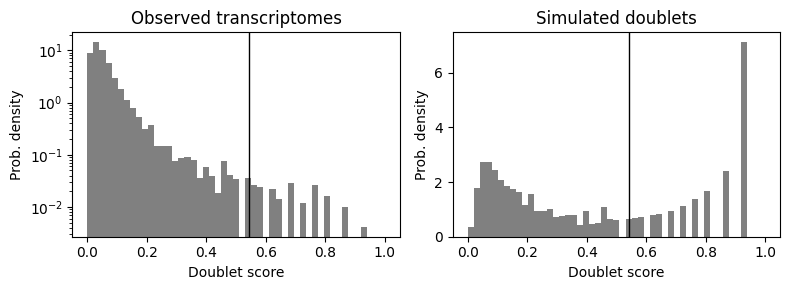

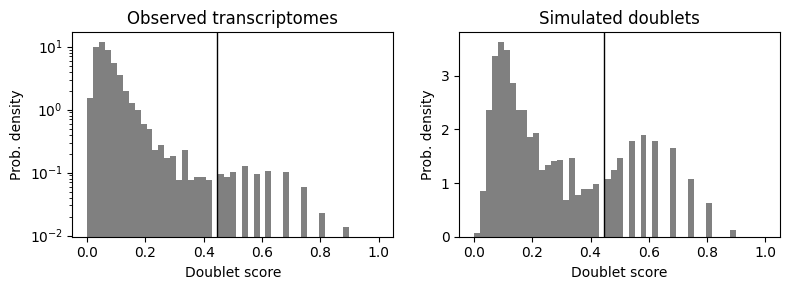

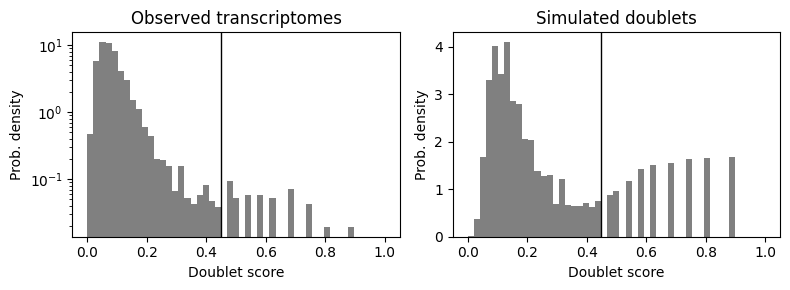

In [11]:
# Plot histograms
for name, scrub in scrub_dict.items():
    scrub.plot_histogram()

In [12]:
# Remove doublets 
adata_mm_dge_filt = adata_mm_dge[adata_mm_dge.obs['doublet_scores'] < 0.54, :]
adata_mm_ncx_zylka_filt = adata_mm_ncx_zylka[adata_mm_ncx_zylka.obs['doublet_scores'] < 0.45, :]
adata_mm_ncx_ruan_filt = adata_mm_ncx_ruan[adata_mm_ncx_ruan.obs['doublet_scores'] < 0.45, :]

In [13]:
# Print number of cells 
adata_filt_list = [adata_mm_dge_filt, adata_mm_ncx_zylka_filt, adata_mm_ncx_ruan_filt]

for i, adata in enumerate(adata_filt_list):
    print(f"Number of cells and genes in dataset {i+1} is:, {adata.X.shape}")

Number of cells and genes in dataset 1 is:, (24094, 27933)
Number of cells and genes in dataset 2 is:, (10751, 21313)
Number of cells and genes in dataset 3 is:, (10163, 21862)


### QC filtering

In [14]:
# Define QC columns 
adata_mm_dge_filt.var['mito'] = adata_mm_dge_filt.var_names.str.startswith('mt-')
adata_mm_ncx_zylka_filt.var['mito'] = adata_mm_ncx_zylka_filt.var_names.str.startswith('mt-')
adata_mm_ncx_ruan_filt.var['mito'] = adata_mm_ncx_ruan_filt.var_names.str.startswith('mt-')

/tmp/ipykernel_3893625/5441080.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_mm_dge_filt.var['mito'] = adata_mm_dge_filt.var_names.str.startswith('mt-')
/tmp/ipykernel_3893625/5441080.py:3: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_mm_ncx_zylka_filt.var['mito'] = adata_mm_ncx_zylka_filt.var_names.str.startswith('mt-')
/tmp/ipykernel_3893625/5441080.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_mm_ncx_ruan_filt.var['mito'] = adata_mm_ncx_ruan_filt.var_names.str.startswith('mt-')


In [15]:
# Compute QC metrics
sc.pp.calculate_qc_metrics(adata_mm_dge_filt, log1p=True, qc_vars=['mito'], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(adata_mm_ncx_zylka_filt, log1p=True, qc_vars=['mito'], inplace=True, percent_top=None)
sc.pp.calculate_qc_metrics(adata_mm_ncx_ruan_filt, log1p=True, qc_vars=['mito'], inplace=True, percent_top=None)

In [16]:
# Add columns
adata_mm_dge_filt.obs['ds'] = 'Linnarsson'
adata_mm_ncx_zylka_filt.obs['ds'] = 'Zylka'
adata_mm_ncx_ruan_filt.obs['ds'] = 'Ruan'

In [17]:
# Print maximum pct_counts_mito
for i, adata in enumerate([adata_mm_dge_filt, adata_mm_ncx_zylka_filt, adata_mm_ncx_ruan_filt]):
    print(f'The maximum pct_counts_mito for dataset {i+1}:', adata.obs['pct_counts_mito'].max())

print('#' *50)

The maximum pct_counts_mito for dataset 1: 67.68958394806728
The maximum pct_counts_mito for dataset 2: 9.987745098039216
The maximum pct_counts_mito for dataset 3: 9.99641705481906
##################################################


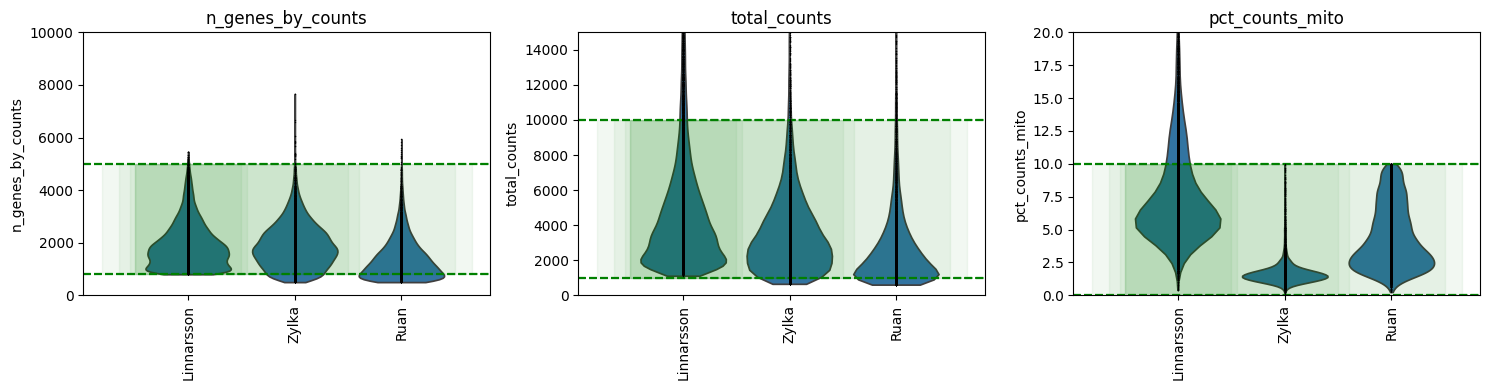

In [18]:
# Generate a dictionary
thresholds = {
    'n_genes_by_counts' : [800, 5000],
    'total_counts' : [1000, 10000],
    'pct_counts_mito' : [0,10], 
    }

limits = {
    'n_genes_by_counts' : [0, 10000],
    'total_counts' : [0, 15000],
    'pct_counts_mito' : [0,20], 
}

# Create subplots
fig, axes = plt.subplots(1, len(thresholds), figsize = (15, 4))

# Create violin plots for each .obs category
for adata in [adata_mm_dge_filt, adata_mm_ncx_zylka_filt, adata_mm_ncx_ruan_filt]:
    for ax, (obs_category, thresh) in zip(axes, thresholds.items()):
        
        sc.pl.violin(adata, [obs_category], groupby = 'ds', 
                     jitter = False, show = False, multi_panel = True, ax = ax, rotation=90.)
        
        for value in thresh:
            ax.axhline(y = value, linestyle = '--', color = 'green')
            x_min, x_max = ax.get_xlim()
            ax.fill_betweenx(y = thresh, x1 = x_min, x2 = x_max, color = 'green', alpha = 0.05)
            ax.set_title(obs_category)
            
            for value in limits:
                ax.set_ylim(limits[obs_category])

plt.tight_layout()

In [19]:
# Define cutoffs 
MITO_cutoff = 10
MIN_COUNTS = 1000
MAX_COUNTS = 10000
MIN_GENES = 800
MAX_GENES = 5000

In [20]:
# Perform filtering
for adata in [adata_mm_dge_filt, adata_mm_ncx_zylka_filt, adata_mm_ncx_ruan_filt]:
    adata = adata[adata.obs['pct_counts_mito'] < MITO_cutoff, :]
    sc.pp.filter_genes(adata, min_cells=np.rint((adata.n_obs*0.20)/100))
    sc.pp.filter_cells(adata, min_counts=MIN_COUNTS)
    sc.pp.filter_cells(adata, max_counts=MAX_COUNTS)
    sc.pp.filter_cells(adata, min_genes=MIN_GENES)
    sc.pp.filter_cells(adata, max_genes=MAX_GENES)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


### Map protein-coding genes

> *** NOTE: Find the downloaded ensembl releases for human and mouse genomes here : '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104'

In [21]:
# Download the ENSEMBL RELEASE 104 

## human
#data = EnsemblRelease(104)
#data.download()
#data.index()
#all_genes = data.genes()
#protein_coding_hs = [gene.gene_name for gene in all_genes if gene.biotype == 'protein_coding']
#len(protein_coding_hs)

## mouse
#data = EnsemblRelease(104, species='mus_musculus')
#data.download()
#data.index()
#all_genes = data.genes()
#protein_coding_mm = [gene.gene_name for gene in all_genes if gene.biotype == 'protein_coding']
#len(protein_coding_hs)

In [22]:
# Import GTF files and keep only protein-coding genes
## human 
human_gtf_path = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104/GRCh38/ensembl104/Homo_sapiens.GRCh38.104.gtf.db'
connection_hs = sqlite3.connect(human_gtf_path)
df_hs = pd.read_sql_query("SELECT * FROM gene;", connection_hs)
df_protein_coding_hs = df_hs[df_hs['gene_biotype'] == 'protein_coding']
## mouse
mouse_gtf_path = '/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/ensembl_release_104/GRCm39/ensembl104/Mus_musculus.GRCm39.104.gtf.db'
connection_mm = sqlite3.connect(mouse_gtf_path)
df_mm = pd.read_sql_query("SELECT * FROM gene;", connection_mm)
df_protein_coding_mm = df_mm[df_mm['gene_biotype'] == 'protein_coding']

In [23]:
# Print the number of protein-coding genes
print(len(df_protein_coding_hs))
print(len(df_protein_coding_mm))

19966
21885


In [24]:
# Keep only protein coding genes
## Polioudakis and Trevino
adata_hs_ncx = adata_hs_ncx[:, adata_hs_ncx.var_names.isin(df_protein_coding_hs['gene_name'].tolist())]
## Linnarsson 
adata_mm_dge_filt = adata_mm_dge_filt[:, adata_mm_dge_filt.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]
## Zylka 
adata_mm_ncx_zylka_filt = adata_mm_ncx_zylka_filt[:, adata_mm_ncx_zylka_filt.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]
## Ruan 
adata_mm_ncx_ruan_filt = adata_mm_ncx_ruan_filt[:, adata_mm_ncx_ruan_filt.var_names.isin(df_protein_coding_mm['gene_name'].tolist())]

In [25]:
## ** This column already exists for Polioudakis and Trevino
adata_mm_dge_filt.obs['dataset_of_origin'] = 'Linnarsson'
adata_mm_ncx_zylka_filt.obs['dataset_of_origin'] = 'Zylka'
adata_mm_ncx_ruan_filt.obs['dataset_of_origin'] = 'Ruan'

/tmp/ipykernel_3893625/3318238434.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_dge_filt.obs['dataset_of_origin'] = 'Linnarsson'
/tmp/ipykernel_3893625/3318238434.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_ncx_zylka_filt.obs['dataset_of_origin'] = 'Zylka'
/tmp/ipykernel_3893625/3318238434.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mm_ncx_ruan_filt.obs['dataset_of_origin'] = 'Ruan'


### Map mouse genes to human orthologues

> *** NOTE: For more information on GProfiler.orth, visit : https://pypi.org/project/gprofiler-official/

In [26]:
# Initialize the gprofiler
gp = GProfiler(return_dataframe=True)

# Extract mouse genes as a list
mouse_genes_linnarsson = adata_mm_dge_filt.var_names.tolist()
mouse_genes_zylka = adata_mm_ncx_zylka_filt.var_names.tolist()
mouse_genes_ruan = adata_mm_ncx_ruan_filt.var_names.tolist()

# Map the extracted genes to human orthologues
ortho_map_linnarsson = gp.orth(organism='mmusculus', query=mouse_genes_linnarsson, target='hsapiens')
ortho_map_zylka = gp.orth(organism='mmusculus', query=mouse_genes_zylka, target='hsapiens')
ortho_map_ruan = gp.orth(organism='mmusculus', query=mouse_genes_ruan, target='hsapiens')

In [27]:
# Remove the genes that were not successfully mapped
# Replace the 'N/A' character with numpy NaN
ortho_map_linnarsson['name'] = ortho_map_linnarsson['name'].replace('N/A', np.nan)
ortho_map_zylka['name'] = ortho_map_zylka['name'].replace('N/A', np.nan)
ortho_map_ruan['name'] = ortho_map_ruan['name'].replace('N/A', np.nan)
# Drop NaNs
ortho_map_linnarsson_clean  = ortho_map_linnarsson.dropna(subset=['name'])
ortho_map_zylka_clean  = ortho_map_zylka.dropna(subset=['name'])
ortho_map_ruan_clean  = ortho_map_ruan.dropna(subset=['name'])

In [28]:
# Remove unmapped genes and keep only 1:1 mappings
cleaned_maps = []

for df in [ortho_map_linnarsson_clean, ortho_map_zylka_clean, ortho_map_ruan_clean]:
    
    for col in ['n_result']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    filtered_df = df[df['n_result'] == 1]

    cleaned_maps.append(filtered_df)

ortho_map_linnarsson_clean, ortho_map_zylka_clean, ortho_map_ruan_clean = cleaned_maps

/tmp/ipykernel_3893625/4169324195.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


In [29]:
# Map the converted genes to the adata.var_name category
## Linnarsson
mapped_genes_linnarsson = dict(zip(ortho_map_linnarsson_clean['incoming'], ortho_map_linnarsson_clean['name']))
adata_mm_dge_filt.var_names = [mapped_genes_linnarsson.get(gene, gene) for gene in adata_mm_dge_filt.var_names]
## Zylka
mapped_genes_zylka = dict(zip(ortho_map_zylka_clean['incoming'], ortho_map_zylka_clean['name']))
adata_mm_ncx_zylka_filt.var_names = [mapped_genes_zylka.get(gene, gene) for gene in adata_mm_ncx_zylka_filt.var_names]
## Ruan
mapped_genes_ruan = dict(zip(ortho_map_ruan_clean['incoming'], ortho_map_ruan_clean['name']))
adata_mm_ncx_ruan_filt.var_names = [mapped_genes_ruan.get(gene, gene) for gene in adata_mm_ncx_ruan_filt.var_names]

In [30]:
# Keep only the human gene names
## Linnarsson
adata_mm_dge_filt = adata_mm_dge_filt[:, adata_mm_dge_filt.var_names.isin(mapped_genes_linnarsson.values())]
print(len(adata_mm_dge_filt.var_names))
## Zylka
adata_mm_ncx_zylka_filt = adata_mm_ncx_zylka_filt[:, adata_mm_ncx_zylka_filt.var_names.isin(mapped_genes_zylka.values())]
print(len(adata_mm_ncx_zylka_filt.var_names))
## Ruan
adata_mm_ncx_ruan_filt = adata_mm_ncx_ruan_filt[:, adata_mm_ncx_ruan_filt.var_names.isin(mapped_genes_ruan.values())]
print(len(adata_mm_ncx_ruan_filt.var_names))

16598
14523
14589


### Concatenate datasets

In [31]:
# Make var_names unique
adata_mm_dge_filt.var_names_make_unique()
adata_mm_ncx_zylka_filt.var_names_make_unique()
adata_mm_ncx_ruan_filt.var_names_make_unique()
adata_hs_ncx.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [32]:
# Concatenate the raw datasets 
adata_combined = ad.concat([adata_hs_ncx, adata_mm_dge_filt, adata_mm_ncx_zylka_filt, adata_mm_ncx_ruan_filt], join = 'inner')
adata_combined

AnnData object with n_obs × n_vars = 113298 × 10828
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'dataset_of_origin'

In [33]:
# Check the 'dataset_of_origin labels
adata_combined.obs['dataset_of_origin'].unique()

array(['Polioudakis', 'Trevino', 'Linnarsson', 'Zylka', 'Ruan'],
      dtype=object)

In [34]:
# Check the sample id column 
adata_combined.obs['sample_id'].unique()

['S_368', 'S_370', 'S_371', 'S_372', 'hft_w20_p3_r1', ..., 'E15_1', 'E15_2', 'E16_2', 'E18_1', 'E18_2']
Length: 41
Categories (41, object): ['10X79_1', '10X79_2', '10X80_1', '10X80_2', ..., 'hft_w21_p5_r1', 'hft_w21_p5_r2', 'hft_w24_p6_r1', 'hft_w24_p6_r2']

### Data normalization, PCA and NN

In [35]:
# Create the layer for raw counts
adata_combined.layers['counts'] = adata_combined.X.toarray().copy()
# Normalize counts
sc.pp.normalize_total(adata_combined, target_sum=1e4, exclude_highly_expressed=True)
adata_combined.layers['normalized_counts'] = adata_combined.X.copy()
# Log-transform
sc.pp.log1p(adata_combined)
adata_combined.layers['log_normalized_counts'] = adata_combined.X.copy()
sc.pp.highly_variable_genes(adata_combined, subset=False, batch_key = 'dataset_of_origin')
# Scale
sc.pp.scale(adata_combined, max_value=10)
adata_combined.layers['log_normalized_scaled_counts'] = adata_combined.X.copy()

In [36]:
# Compute the PCA and NNs
sc.tl.pca(adata_combined, n_comps = 50, svd_solver='arpack', random_state=111, use_highly_variable=True)
sc.pp.neighbors(adata_combined, n_neighbors= 50, n_pcs=30, random_state=111)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2025-06-11 20:11:20.096579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 20:11:20.135274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 20:11:20.135302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for pl

In [37]:
# Compute UMAPs
sc.tl.umap(adata_combined, random_state=111)

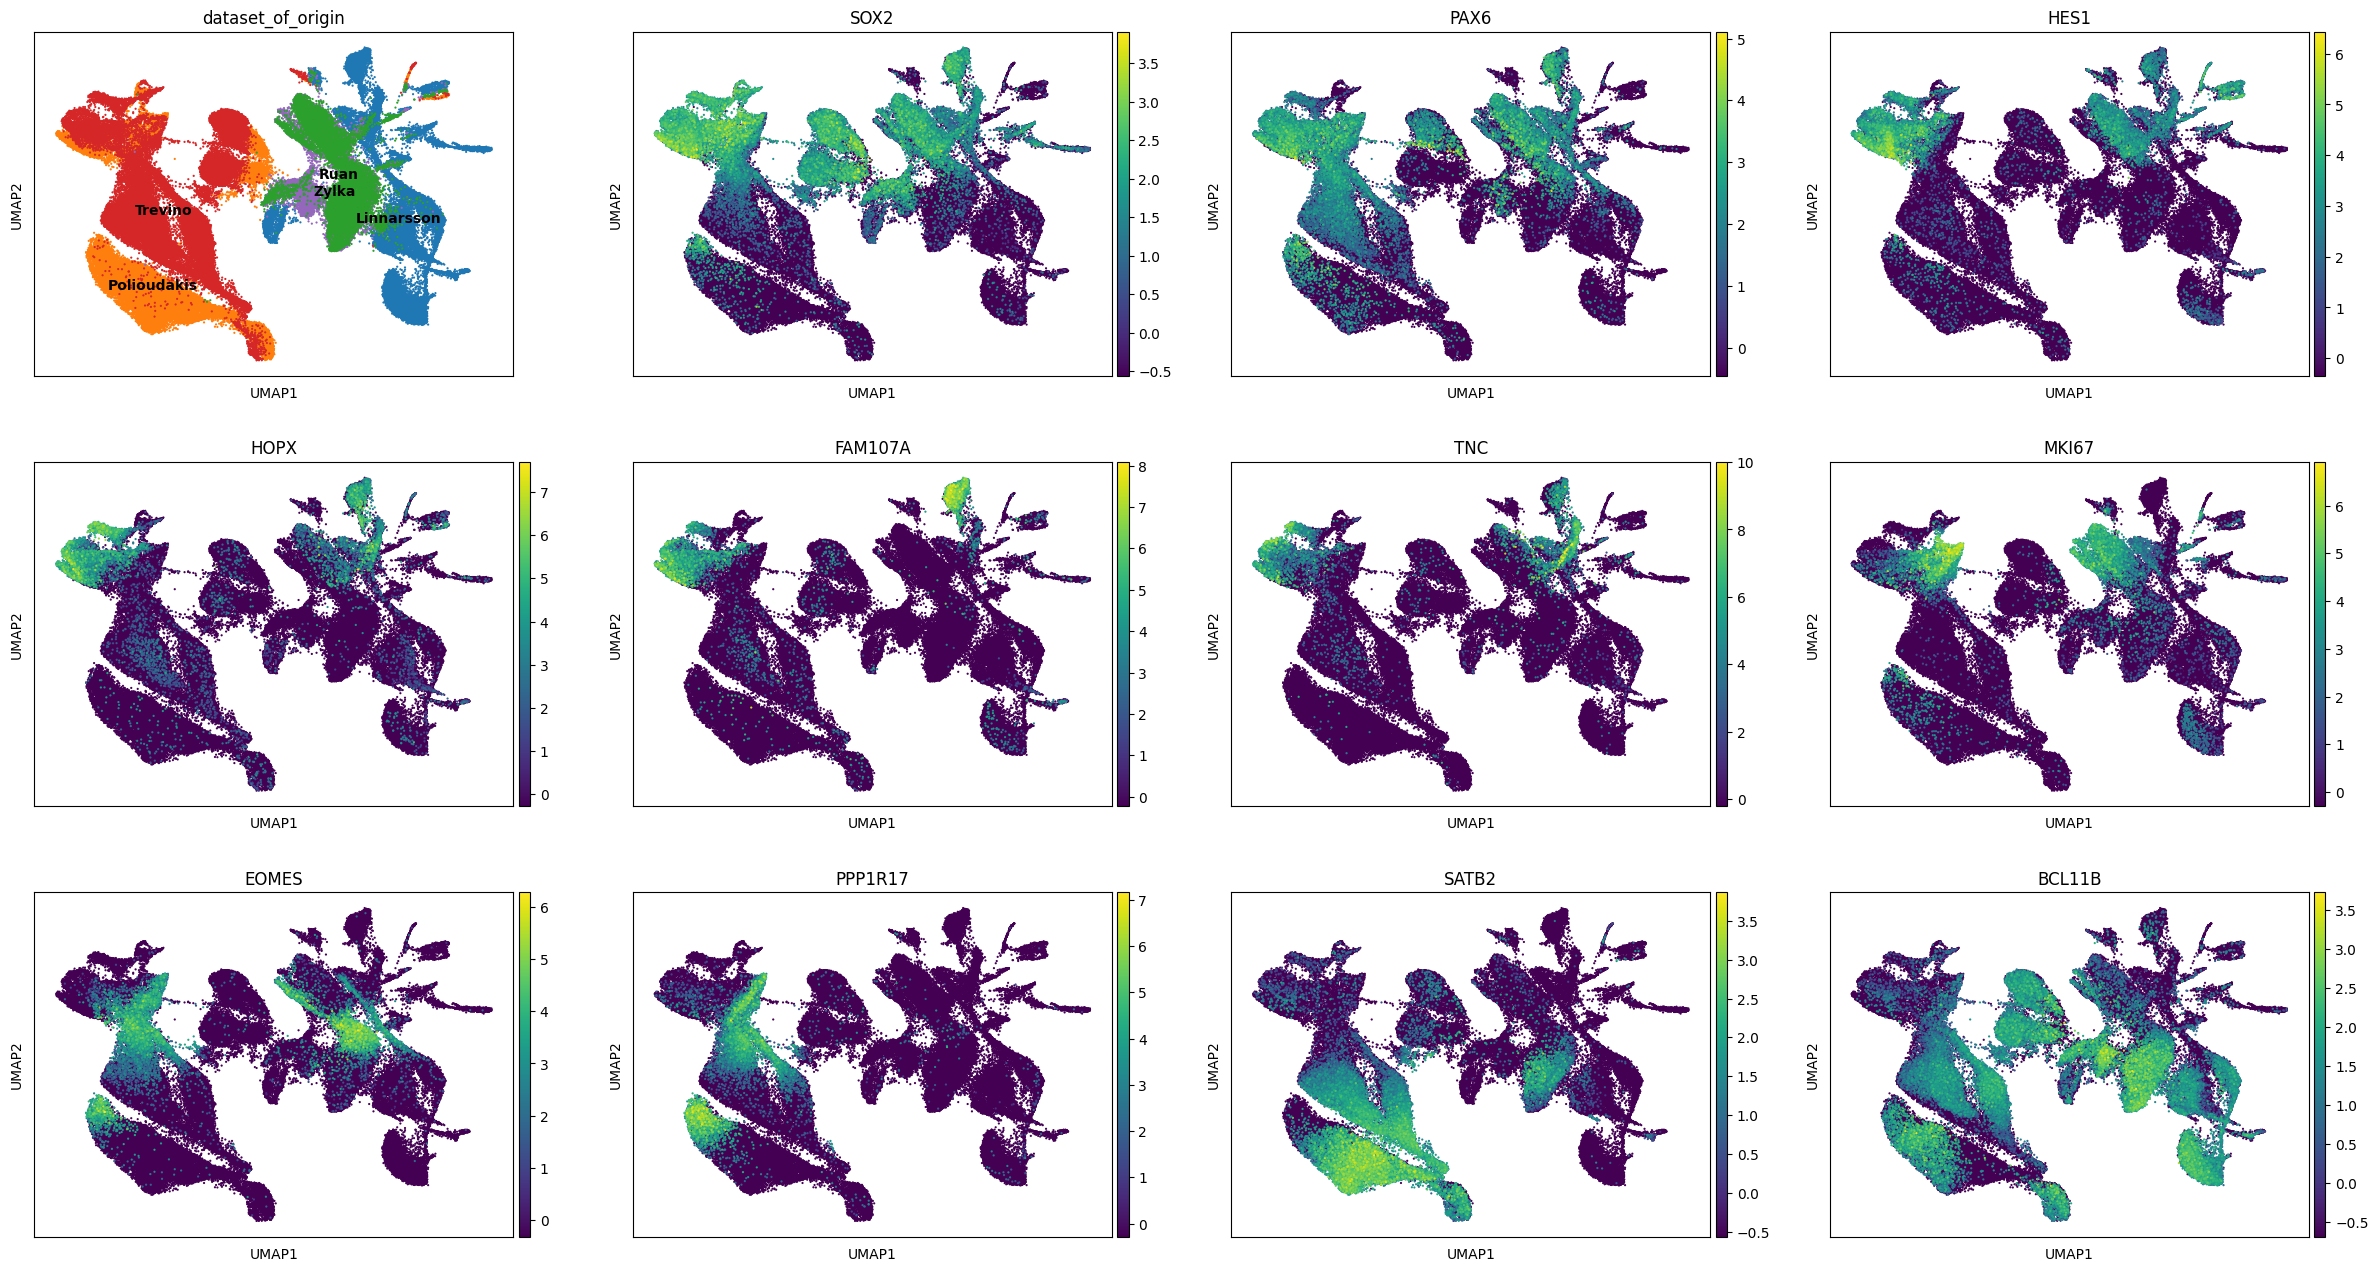

In [38]:
# Plot the UMAPs
sc.pl.umap(adata_combined, color=["dataset_of_origin", 'SOX2', 'PAX6', 'HES1', 'HOPX', 'FAM107A', 'TNC', 'MKI67', 'EOMES', 'PPP1R17', 'SATB2', 'BCL11B'],legend_loc="on data", show=False, size = 10)
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/processing/Adata_concatenated_marker_genes.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Save the data

In [39]:
adata_combined.write_h5ad(os.path.join(home_path, 'data_versions/Adata_normalized.h5ad'))